<a href="https://colab.research.google.com/github/wilsonh22/435Assn1/blob/main/438Ass6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from sklearn.preprocessing import normalize
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, lit, struct, array, explode
from pyspark.sql.types import ArrayType, FloatType, IntegerType, StructType, StructField
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import PCA as SparkPCA

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# Initialize Spark
spark = SparkSession.builder \
    .appName("ReverseImageSearch") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
print("Spark Session initialized")
print(f"Spark version: {spark.version}")

print("\nAll libraries imported successfully!")

Spark Session initialized
Spark version: 4.0.1

All libraries imported successfully!


In [ ]:
# DATA LOADING AND PREPROCESSING

# Fashion MNIST class names
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def load_fashion_mnist():
    """Load Fashion MNIST dataset"""
    print("Loading Fashion MNIST dataset...")

    from tensorflow.keras.datasets import fashion_mnist
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

    # Normalize pixel values to [0, 1]
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    # Add channel dimension for CNN
    X_train = np.expand_dims(X_train, axis=1)
    X_test = np.expand_dims(X_test, axis=1)

    print(f"✓ Training set: {X_train.shape}")
    print(f"✓ Test set: {X_test.shape}")

    return X_train, y_train, X_test, y_test


Loading Fashion MNIST dataset...
✓ Training set: (60000, 1, 28, 28)
✓ Test set: (10000, 1, 28, 28)

 Dataset Statistics:
   Training: 48,000 images
   Validation: 12,000 images
   Test: 10,000 images
   Image size: 28×28 pixels
   Classes: 10


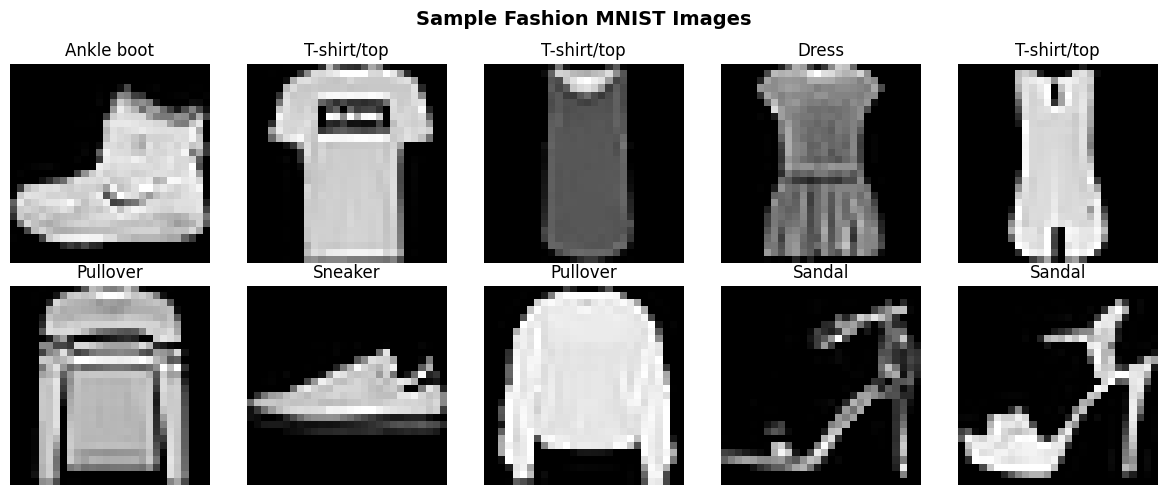

In [ ]:
# Load data
X_train, y_train, X_test, y_test = load_fashion_mnist()

# Compute 80/20 split
val_ratio = 0.2
val_size = int(len(X_train) * val_ratio)

# Split
X_val = X_train[-val_size:]
y_val = y_train[-val_size:]
X_train_split = X_train[:-val_size]
y_train_split = y_train[:-val_size]

print(f"\n Dataset Statistics:")
print(f"   Training: {len(X_train_split):,} images")
print(f"   Validation: {len(X_val):,} images")
print(f"   Test: {len(X_test):,} images")
print(f"   Image size: 28×28 pixels")
print(f"   Classes: {len(CLASS_NAMES)}")

# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i, 0], cmap='gray')
    ax.set_title(f"{CLASS_NAMES[y_train[i]]}")
    ax.axis('off')
plt.suptitle("Sample Fashion MNIST Images", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
#CNN ARCHITECTURE

class FeatureExtractorCNN(nn.Module):
    "CNN for extracting image features"
    "later used in training"
    def __init__(self, feature_dim=128):
        super(FeatureExtractorCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, feature_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


TRAINING CNN FEATURE EXTRACTOR
Using device: cpu

Epoch  1/10 | Train Loss: 0.4444 | Val Loss: 0.3152 | Val Acc: 0.8822
Epoch  2/10 | Train Loss: 0.2768 | Val Loss: 0.2906 | Val Acc: 0.8911
Epoch  3/10 | Train Loss: 0.2346 | Val Loss: 0.2429 | Val Acc: 0.9127
Epoch  4/10 | Train Loss: 0.2018 | Val Loss: 0.2876 | Val Acc: 0.8982
Epoch  5/10 | Train Loss: 0.1807 | Val Loss: 0.2244 | Val Acc: 0.9206
Epoch  6/10 | Train Loss: 0.1609 | Val Loss: 0.2237 | Val Acc: 0.9182
Epoch  7/10 | Train Loss: 0.1423 | Val Loss: 0.2290 | Val Acc: 0.9207
Epoch  8/10 | Train Loss: 0.1236 | Val Loss: 0.2478 | Val Acc: 0.9193
Epoch  9/10 | Train Loss: 0.1129 | Val Loss: 0.2785 | Val Acc: 0.9185
Epoch 10/10 | Train Loss: 0.0595 | Val Loss: 0.2426 | Val Acc: 0.9293

✓ Training completed!
✓ Best validation accuracy: 0.9293


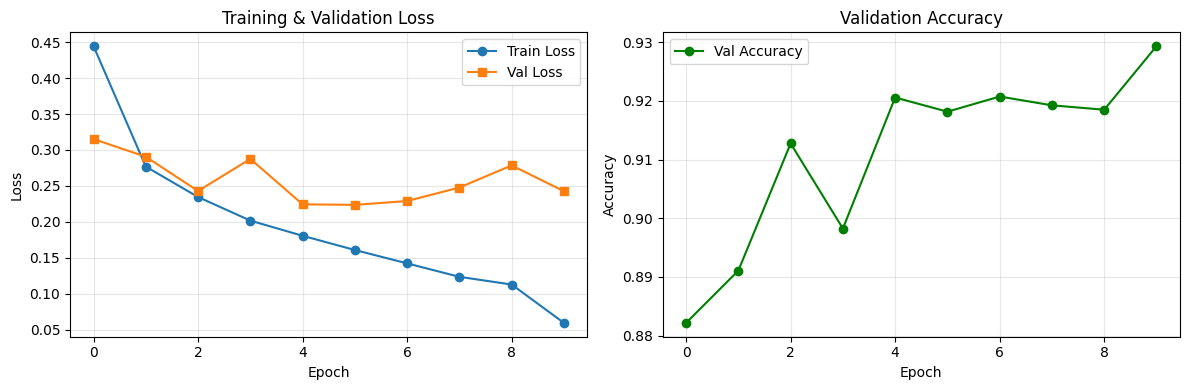

In [ ]:
# MODEL TRAINING

def train_feature_extractor(X_train, y_train, X_val, y_val,
                           feature_dim=128, epochs=10, batch_size=128):
    """Train the CNN feature extractor"""
    print("="*70)
    print("TRAINING CNN FEATURE EXTRACTOR")
    print("="*70)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")

    # Prepare data
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.LongTensor(y_val)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model
    model = FeatureExtractorCNN(feature_dim=feature_dim).to(device)
    classifier = nn.Linear(feature_dim, 10).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(list(model.parameters()) + list(classifier.parameters()), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    # Training history
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0

    for epoch in range(epochs):
        # Training
        model.train()
        classifier.train()
        train_loss = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            features = model(batch_X)
            outputs = classifier(features)
            loss = criterion(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        classifier.eval()
        with torch.no_grad():
            X_val_device = X_val_tensor.to(device)
            y_val_device = y_val_tensor.to(device)

            val_features = model(X_val_device)
            val_outputs = classifier(val_features)
            val_loss = criterion(val_outputs, y_val_device)

            _, predicted = torch.max(val_outputs, 1)
            val_acc = (predicted == y_val_device).sum().item() / len(y_val_device)

        scheduler.step(val_loss)

        # Store history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss.item())
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1:2d}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc

    print(f"\n✓ Training completed!")
    print(f"✓ Best validation accuracy: {best_val_acc:.4f}")

    # Plot training history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_loss'], label='Train Loss', marker='o')
    ax1.plot(history['val_loss'], label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training & Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(history['val_acc'], label='Val Accuracy', marker='o', color='green')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return model

# Train the model
trained_model = train_feature_extractor(
    X_train_split, y_train_split, X_val, y_val,
    feature_dim=128, epochs=10
)


In [ ]:
#Dimensionality Reduction

class SparkDimensionalityReducer:
    "PySpark-based PCA for dimensionality reduction"
    "Make vector smaller ex.128 -> 64 (dimensions)"
    #Initializes the Dimensionality Reducer
    def __init__(self, spark, n_components=64):
        self.spark = spark
        self.n_components = n_components
        self.pca_model = None
        self.mean = None
        self.std = None

    def fit(self, features):
      #standardizes the features
        print(f"Applying PySpark PCA: {features.shape[1]} → {self.n_components} dimensions")
        self.mean = np.mean(features, axis=0)
        self.std = np.std(features, axis=0) + 1e-8
        features_normalized = (features - self.mean) / self.std

        features_list = [(int(i), Vectors.dense(feat.tolist()))
                        for i, feat in enumerate(features_normalized)]
        df = self.spark.createDataFrame(features_list, ["id", "features"])

      #compute the PCA
        pca = SparkPCA(k=self.n_components, inputCol="features", outputCol="pca_features")
        self.pca_model = pca.fit(df)
        print(f"✓ PCA model fitted")

    def transform(self, features):
      #standardized using the mean and std from fit
        features_normalized = (features - self.mean) / self.std
        features_list = [(int(i), Vectors.dense(feat.tolist()))
                        for i, feat in enumerate(features_normalized)]
        df = self.spark.createDataFrame(features_list, ["id", "features"])
      #transformed using the PCA
        transformed_df = self.pca_model.transform(df)
        result = transformed_df.select("id", "pca_features").orderBy("id").collect()
        return np.array([row.pca_features.toArray() for row in result])

    def fit_transform(self, features):
      #call the fit function
        self.fit(features)
        return self.transform(features)

In [ ]:
#  nearest-neighbor search

class SimilaritySearchEngine:
    "KD-Tree based similarity search"
    #Initializes
    def __init__(self, metric='euclidean'):
        self.metric = metric
        self.database_features = None
        self.database_labels = None
        self.kdtree = None
        self.normalized_features = None

    def build_index(self, features, labels):
      #build the index
        print(f"Building KD-Tree index ({self.metric} metric)...")
        self.database_features = features
        self.database_labels = labels

        if self.metric == 'cosine':
            self.normalized_features = normalize(features, norm='l2')
            self.kdtree = KDTree(self.normalized_features, leaf_size=40)
        else:
            self.kdtree = KDTree(features, leaf_size=40, metric=self.metric)

        print(f"✓ Index built for {len(features):,} items")

    def search(self, query_feature, k=20):
      #Performs a single nearest-neighbor search
        if self.metric == 'cosine':
            query_normalized = normalize(query_feature.reshape(1, -1), norm='l2')
            distances, indices = self.kdtree.query(query_normalized, k=k)
        else:
            distances, indices = self.kdtree.query(query_feature.reshape(1, -1), k=k)

        return indices.flatten(), distances.flatten()

    def batch_search(self, query_features, k=20):
      #sequential nearest-neighbor search
        all_indices = []
        all_distances = []
        for query_feature in query_features:
            indices, distances = self.search(query_feature, k=k)
            all_indices.append(indices)
            all_distances.append(distances)
        return all_indices, all_distances

In [ ]:
# DATABASE BUILDING

def extract_features_batch(model, X, batch_size=256):
    """Extract features from images"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    features_list = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            batch = torch.FloatTensor(X[i:i+batch_size]).to(device)
            batch_features = model(batch)
            features_list.append(batch_features.cpu().numpy())

    return np.vstack(features_list)

print("BUILDING DATABASE")

# Extract features from training set
print("\n Extracting features from training images...")
start_time = time.time()
database_features = extract_features_batch(trained_model, X_train_split)
extraction_time = time.time() - start_time

print(f" Feature extraction completed in {extraction_time:.2f} seconds")
print(f" Feature shape: {database_features.shape}")
print(f" Feature dimension: {database_features.shape[1]}")

# Apply PCA for dimensionality reduction
print("\n Applying PCA for optimization...")
pca_reducer = SparkDimensionalityReducer(spark, n_components=64)
database_features_pca = pca_reducer.fit_transform(database_features)

print(f" Reduced features shape: {database_features_pca.shape}")
print(f" Compression ratio: {database_features.shape[1]/database_features_pca.shape[1]:.1f}x")

# Build search indices
print("\n Building search indices...")

# Euclidean vs. Cosine which better?

# Euclidean distance index
search_engine_euclidean = SimilaritySearchEngine(metric='euclidean')
search_engine_euclidean.build_index(database_features_pca, y_train_split)

# Cosine similarity index
search_engine_cosine = SimilaritySearchEngine(metric='cosine')
search_engine_cosine.build_index(database_features_pca, y_train_split)

print("\n✓ Database building completed!")
print(f"✓ Total items in database: {len(database_features_pca):,}")


BUILDING DATABASE

 Extracting features from training images...
 Feature extraction completed in 40.48 seconds
 Feature shape: (48000, 128)
 Feature dimension: 128

 Applying PCA for optimization...
Applying PySpark PCA: 128 → 64 dimensions
✓ PCA model fitted
 Reduced features shape: (48000, 64)
 Compression ratio: 2.0x

 Building search indices...
Building KD-Tree index (euclidean metric)...
✓ Index built for 48,000 items
Building KD-Tree index (cosine metric)...
✓ Index built for 48,000 items

✓ Database building completed!
✓ Total items in database: 48,000



 Extracting features from test images...
 Test features extracted: (10000, 64)
EVALUATING: Euclidean Distance + PCA

 Running evaluation on 1,000 queries...
 Search completed in 1.5551 seconds
 Average time per query: 1.56 ms

                           ACCURACY METRICS                           
----------------------------------------------------------------------
Top-20 Accuracy (Mean):   0.9194 ± 0.2315
Top-20 Accuracy (Median): 1.0000

                            PRECISION @ K                             
----------------------------------------------------------------------
Precision@ 1: 0.9190
Precision@ 5: 0.9212
Precision@10: 0.9213
Precision@20: 0.9194

                            OTHER METRICS                             
----------------------------------------------------------------------
Recall@20:  0.0038
MAP Score:   0.9279

                          EFFICIENCY METRICS                          
----------------------------------------------------------------------
Tot

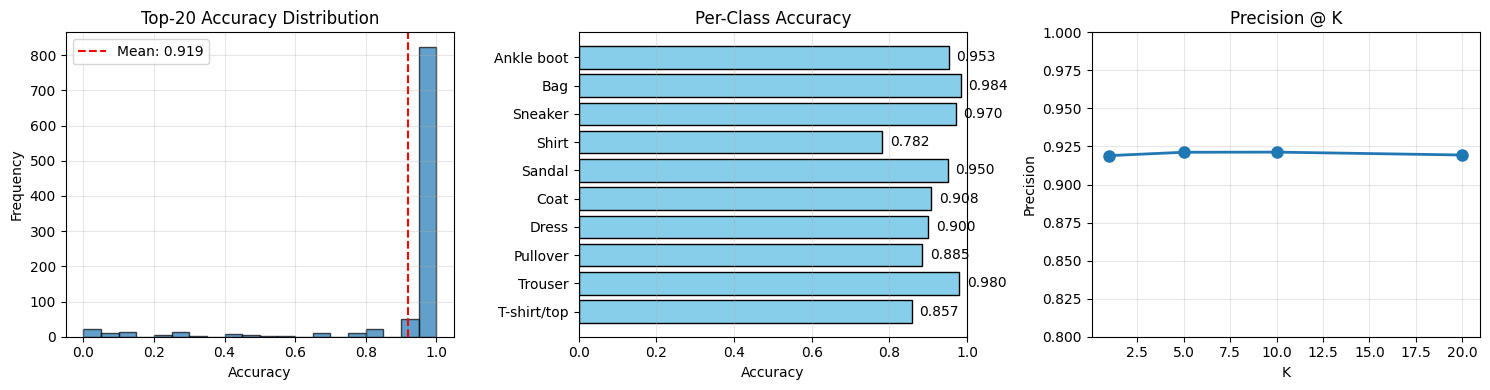

EVALUATING: Cosine Similarity + PCA

 Running evaluation on 1,000 queries...
 Search completed in 1.2055 seconds
 Average time per query: 1.21 ms

                           ACCURACY METRICS                           
----------------------------------------------------------------------
Top-20 Accuracy (Mean):   0.9216 ± 0.2352
Top-20 Accuracy (Median): 1.0000

                            PRECISION @ K                             
----------------------------------------------------------------------
Precision@ 1: 0.9270
Precision@ 5: 0.9214
Precision@10: 0.9215
Precision@20: 0.9216

                            OTHER METRICS                             
----------------------------------------------------------------------
Recall@20:  0.0038
MAP Score:   0.9287

                          EFFICIENCY METRICS                          
----------------------------------------------------------------------
Total search time: 1.2055 seconds
Avg search time:   1.21 ms
Throughput:        829.

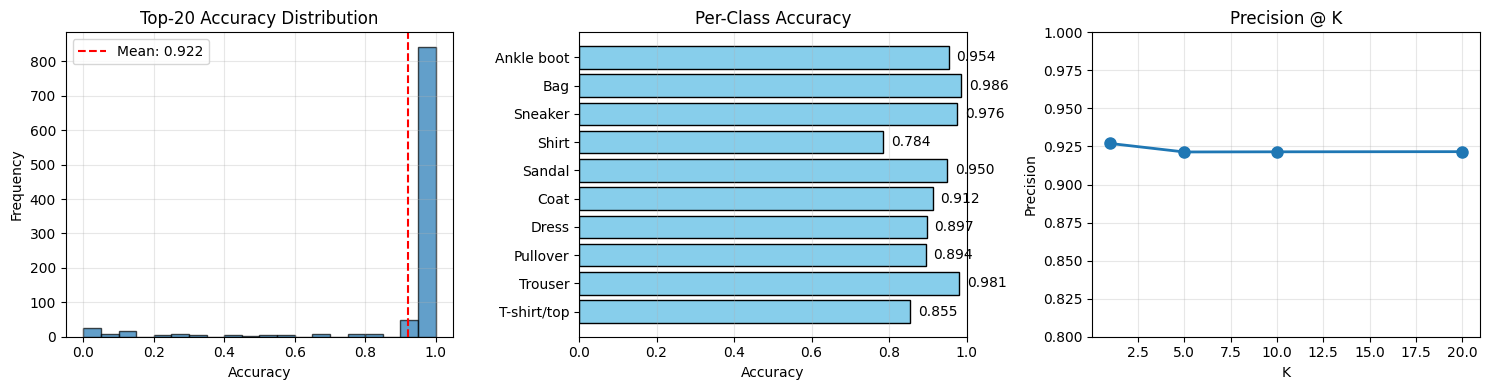

In [ ]:
# EVALUATION METRICS
class SearchEvaluator:
    """Comprehensive evaluation metrics"""

    @staticmethod
    def calculate_accuracy(query_labels, result_indices, database_labels, k=20):
        accuracies = []
        for query_label, indices in zip(query_labels, result_indices):
            result_labels = database_labels[indices[:k]]
            accuracy = np.mean(result_labels == query_label)
            accuracies.append(accuracy)
        return np.array(accuracies)

    @staticmethod
    def calculate_precision_at_k(query_labels, result_indices, database_labels, k_values=[1, 5, 10, 20]):
        precisions = {k: [] for k in k_values}
        for query_label, indices in zip(query_labels, result_indices):
            for k in k_values:
                result_labels = database_labels[indices[:k]]
                precision = np.mean(result_labels == query_label)
                precisions[k].append(precision)
        return {k: np.mean(precisions[k]) for k in k_values}

    @staticmethod
    def calculate_recall_at_k(query_labels, result_indices, database_labels, k=20):
        recalls = []
        for query_label, indices in zip(query_labels, result_indices):
            total_relevant = np.sum(database_labels == query_label)
            result_labels = database_labels[indices[:k]]
            retrieved_relevant = np.sum(result_labels == query_label)
            recall = retrieved_relevant / total_relevant if total_relevant > 0 else 0
            recalls.append(recall)
        return np.array(recalls)

    @staticmethod
    def calculate_map(query_labels, result_indices, database_labels, k=20):
        aps = []
        for query_label, indices in zip(query_labels, result_indices):
            result_labels = database_labels[indices[:k]]
            relevant_positions = np.where(result_labels == query_label)[0] + 1
            if len(relevant_positions) == 0:
                aps.append(0)
            else:
                precisions_at_relevant = []
                for pos in relevant_positions:
                    precision_at_pos = np.sum(result_labels[:pos] == query_label) / pos
                    precisions_at_relevant.append(precision_at_pos)
                aps.append(np.mean(precisions_at_relevant))
        return np.mean(aps)

    @staticmethod
    def per_class_accuracy(query_labels, result_indices, database_labels, k=20):
        class_accuracies = {}
        for class_id in range(10):
            mask = query_labels == class_id
            if np.sum(mask) == 0:
                continue
            class_query_labels = query_labels[mask]
            class_result_indices = [result_indices[i] for i in range(len(result_indices)) if mask[i]]
            accuracies = SearchEvaluator.calculate_accuracy(
                class_query_labels, class_result_indices, database_labels, k
            )
            class_accuracies[class_id] = np.mean(accuracies)
        return class_accuracies

def evaluate_system(search_engine, query_features, query_labels, database_labels, k=20, system_name="System"):
    """Comprehensive system evaluation"""

    print(f"EVALUATING: {system_name}")

    num_queries = len(query_features)
    print(f"\n Running evaluation on {num_queries:,} queries...")

    # Perform batch search with timing
    start_time = time.time()
    all_indices, all_distances = search_engine.batch_search(query_features, k=k)
    total_search_time = time.time() - start_time
    avg_search_time = total_search_time / num_queries

    print(f" Search completed in {total_search_time:.4f} seconds")
    print(f" Average time per query: {avg_search_time*1000:.2f} ms")

    # Calculate metrics
    evaluator = SearchEvaluator()
    accuracies = evaluator.calculate_accuracy(query_labels, all_indices, database_labels, k=k)
    precision_at_k = evaluator.calculate_precision_at_k(query_labels, all_indices, database_labels)
    recalls = evaluator.calculate_recall_at_k(query_labels, all_indices, database_labels, k=k)
    map_score = evaluator.calculate_map(query_labels, all_indices, database_labels, k=k)
    class_accuracies = evaluator.per_class_accuracy(query_labels, all_indices, database_labels, k=k)

    # Print results
    print(f"\n{'ACCURACY METRICS':^70}")
    print("-"*70)
    print(f"Top-{k} Accuracy (Mean):   {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"Top-{k} Accuracy (Median): {np.median(accuracies):.4f}")

    print(f"\n{'PRECISION @ K':^70}")
    print("-"*70)
    for k_val, prec in sorted(precision_at_k.items()):
        print(f"Precision@{k_val:2d}: {prec:.4f}")

    print(f"\n{'OTHER METRICS':^70}")
    print("-"*70)
    print(f"Recall@{k}:  {np.mean(recalls):.4f}")
    print(f"MAP Score:   {map_score:.4f}")

    print(f"\n{'EFFICIENCY METRICS':^70}")
    print("-"*70)
    print(f"Total search time: {total_search_time:.4f} seconds")
    print(f"Avg search time:   {avg_search_time*1000:.2f} ms")
    print(f"Throughput:        {num_queries/total_search_time:.2f} queries/sec")

    print(f"\n{'PER-CLASS ACCURACY':^70}")
    print("-"*70)
    for class_id, acc in sorted(class_accuracies.items()):
        print(f"{CLASS_NAMES[class_id]:15s}: {acc:.4f}")

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Accuracy distribution
    axes[0].hist(accuracies, bins=20, edgecolor='black', alpha=0.7)
    axes[0].axvline(np.mean(accuracies), color='red', linestyle='--', label=f'Mean: {np.mean(accuracies):.3f}')
    axes[0].set_xlabel('Accuracy')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Top-20 Accuracy Distribution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Per-class accuracy
    classes = [CLASS_NAMES[i] for i in sorted(class_accuracies.keys())]
    accs = [class_accuracies[i] for i in sorted(class_accuracies.keys())]
    bars = axes[1].barh(classes, accs, color='skyblue', edgecolor='black')
    axes[1].set_xlabel('Accuracy')
    axes[1].set_title('Per-Class Accuracy')
    axes[1].set_xlim(0, 1)
    axes[1].grid(True, alpha=0.3, axis='x')
    for i, (bar, acc) in enumerate(zip(bars, accs)):
        axes[1].text(acc + 0.02, i, f'{acc:.3f}', va='center')

    # Precision@K
    k_vals = sorted(precision_at_k.keys())
    prec_vals = [precision_at_k[k] for k in k_vals]
    axes[2].plot(k_vals, prec_vals, marker='o', linewidth=2, markersize=8)
    axes[2].set_xlabel('K')
    axes[2].set_ylabel('Precision')
    axes[2].set_title('Precision @ K')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylim(0.8, 1.0)

    plt.tight_layout()
    plt.show()

    return {
        'accuracy': np.mean(accuracies),
        'precision_at_k': precision_at_k,
        'recall': np.mean(recalls),
        'map': map_score,
        'avg_search_time': avg_search_time,
        'class_accuracies': class_accuracies
    }

# Extract test features
print("\n Extracting features from test images...")
test_features = extract_features_batch(trained_model, X_test)
test_features_pca = pca_reducer.transform(test_features)
print(f" Test features extracted: {test_features_pca.shape}")

# Sample 1000 queries for evaluation
num_eval_queries = 1000
eval_indices = np.random.choice(len(X_test), num_eval_queries, replace=False)
eval_features = test_features_pca[eval_indices]
eval_labels = y_test[eval_indices]

# Evaluate Euclidean distance
results_euclidean = evaluate_system(
    search_engine_euclidean,
    eval_features,
    eval_labels,
    y_train_split,
    k=20,
    system_name="Euclidean Distance + PCA"
)

# Evaluate Cosine similarity
results_cosine = evaluate_system(
    search_engine_cosine,
    eval_features,
    eval_labels,
    y_train_split,
    k=20,
    system_name="Cosine Similarity + PCA"
)

In [ ]:
# REVERSE SEARCH DEMONSTRATIONS

def visualize_search_results(query_image, query_label, search_engine,
                            database_images, database_labels, k=10):
    """Visualize query and top-K results"""

    # Extract query features
    query_feature = extract_features_batch(trained_model, query_image.reshape(1, 1, 28, 28))
    query_feature_pca = pca_reducer.transform(query_feature)

    # Search
    start_time = time.time()
    indices, distances = search_engine.search(query_feature_pca[0], k=k)
    search_time = time.time() - start_time

    # Get results
    result_images = database_images[indices]
    result_labels = database_labels[indices]

    # Calculate accuracy
    accuracy = np.mean(result_labels == query_label)

    # Visualize
    fig = plt.figure(figsize=(18, 12))

    # Query image
    ax_query = plt.subplot(4, 6, 1)
    ax_query.imshow(query_image.squeeze(), cmap='gray') # Squeeze to remove channel dimension
    ax_query.set_title(f"QUERY\n{CLASS_NAMES[query_label]}",
                      fontsize=12, fontweight='bold', color='red')
    ax_query.axis('off')

    # Top-K results
    for i in range(min(k, 23)):
        ax = plt.subplot(4, 6, i+2)
        ax.imshow(result_images[i].squeeze(), cmap='gray') # Squeeze to remove channel dimension

        match = "good" if result_labels[i] == query_label else "bad"
        color = 'green' if result_labels[i] == query_label else 'red'

        ax.set_title(f"{match} Rank {i+1}\n{CLASS_NAMES[result_labels[i]]}\nDist: {distances[i]:.2f}",
                    fontsize=9, color=color)
        ax.axis('off')

    plt.suptitle(f"Reverse Image Search Results | Search Time: {search_time*1000:.2f}ms | Accuracy: {accuracy:.1%}",
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print detailed results
    print(f"QUERY: {CLASS_NAMES[query_label]}")
    print(f"Search Time: {search_time*1000:.2f} ms")
    print(f"Top-{k} Accuracy: {accuracy:.4f}\n")

    print(f"{'Rank':<6} {'Match':<7} {'Label':<15} {'Distance':<10}")
    print("-"*70)
    for i, (label, dist) in enumerate(zip(result_labels, distances)):
        match = "✓" if label == query_label else "✗"
        print(f"{i+1:<6} {match:<7} {CLASS_NAMES[label]:<15} {dist:<10.4f}")

    return indices, distances, accuracy

print("REVERSE IMAGE SEARCH DEMONSTRATIONS")

# Select diverse examples
print("\n Selecting diverse query examples...")

# Get one example from each class
query_examples = []
for class_id in range(10):
    # Find the first index in X_test that matches the current class_id
    try:
        # np.where returns a tuple of arrays, we take the first element of the first array
        idx = np.where(y_test == class_id)[0][0]
        query_examples.append((X_test[idx], y_test[idx]))
    except IndexError:
        print(f"Warning: No example found for class {class_id}.")

print(f"Found {len(query_examples)} diverse query examples.")

REVERSE IMAGE SEARCH DEMONSTRATIONS

 Selecting diverse query examples...
Found 10 diverse query examples.


DISPLAYING REVERSE SEARCH RESULTS (Euclidean Distance)

Query 1: T-shirt/top


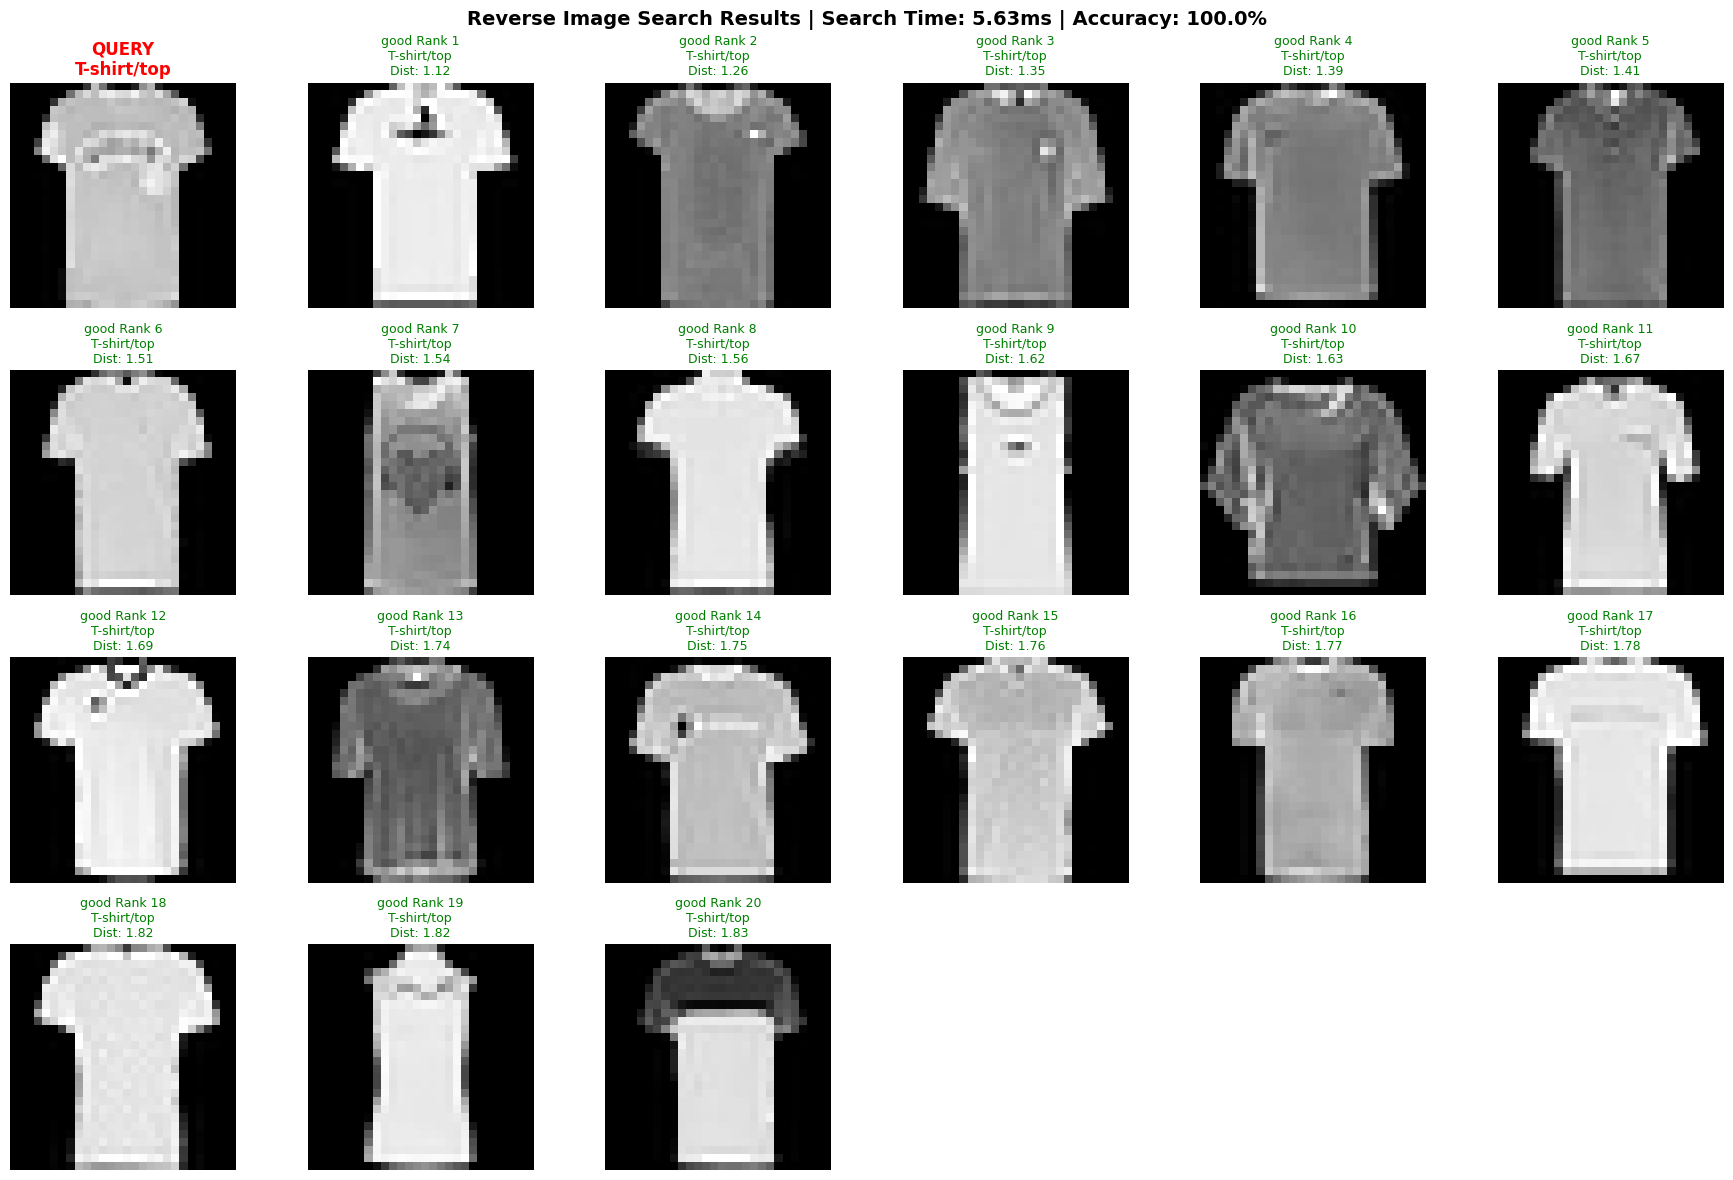

QUERY: T-shirt/top
Search Time: 5.63 ms
Top-20 Accuracy: 1.0000

Rank   Match   Label           Distance  
----------------------------------------------------------------------
1      ✓       T-shirt/top     1.1227    
2      ✓       T-shirt/top     1.2601    
3      ✓       T-shirt/top     1.3547    
4      ✓       T-shirt/top     1.3940    
5      ✓       T-shirt/top     1.4113    
6      ✓       T-shirt/top     1.5120    
7      ✓       T-shirt/top     1.5399    
8      ✓       T-shirt/top     1.5613    
9      ✓       T-shirt/top     1.6225    
10     ✓       T-shirt/top     1.6315    
11     ✓       T-shirt/top     1.6673    
12     ✓       T-shirt/top     1.6871    
13     ✓       T-shirt/top     1.7409    
14     ✓       T-shirt/top     1.7451    
15     ✓       T-shirt/top     1.7555    
16     ✓       T-shirt/top     1.7670    
17     ✓       T-shirt/top     1.7777    
18     ✓       T-shirt/top     1.8163    
19     ✓       T-shirt/top     1.8174    
20     ✓       T-shirt/t

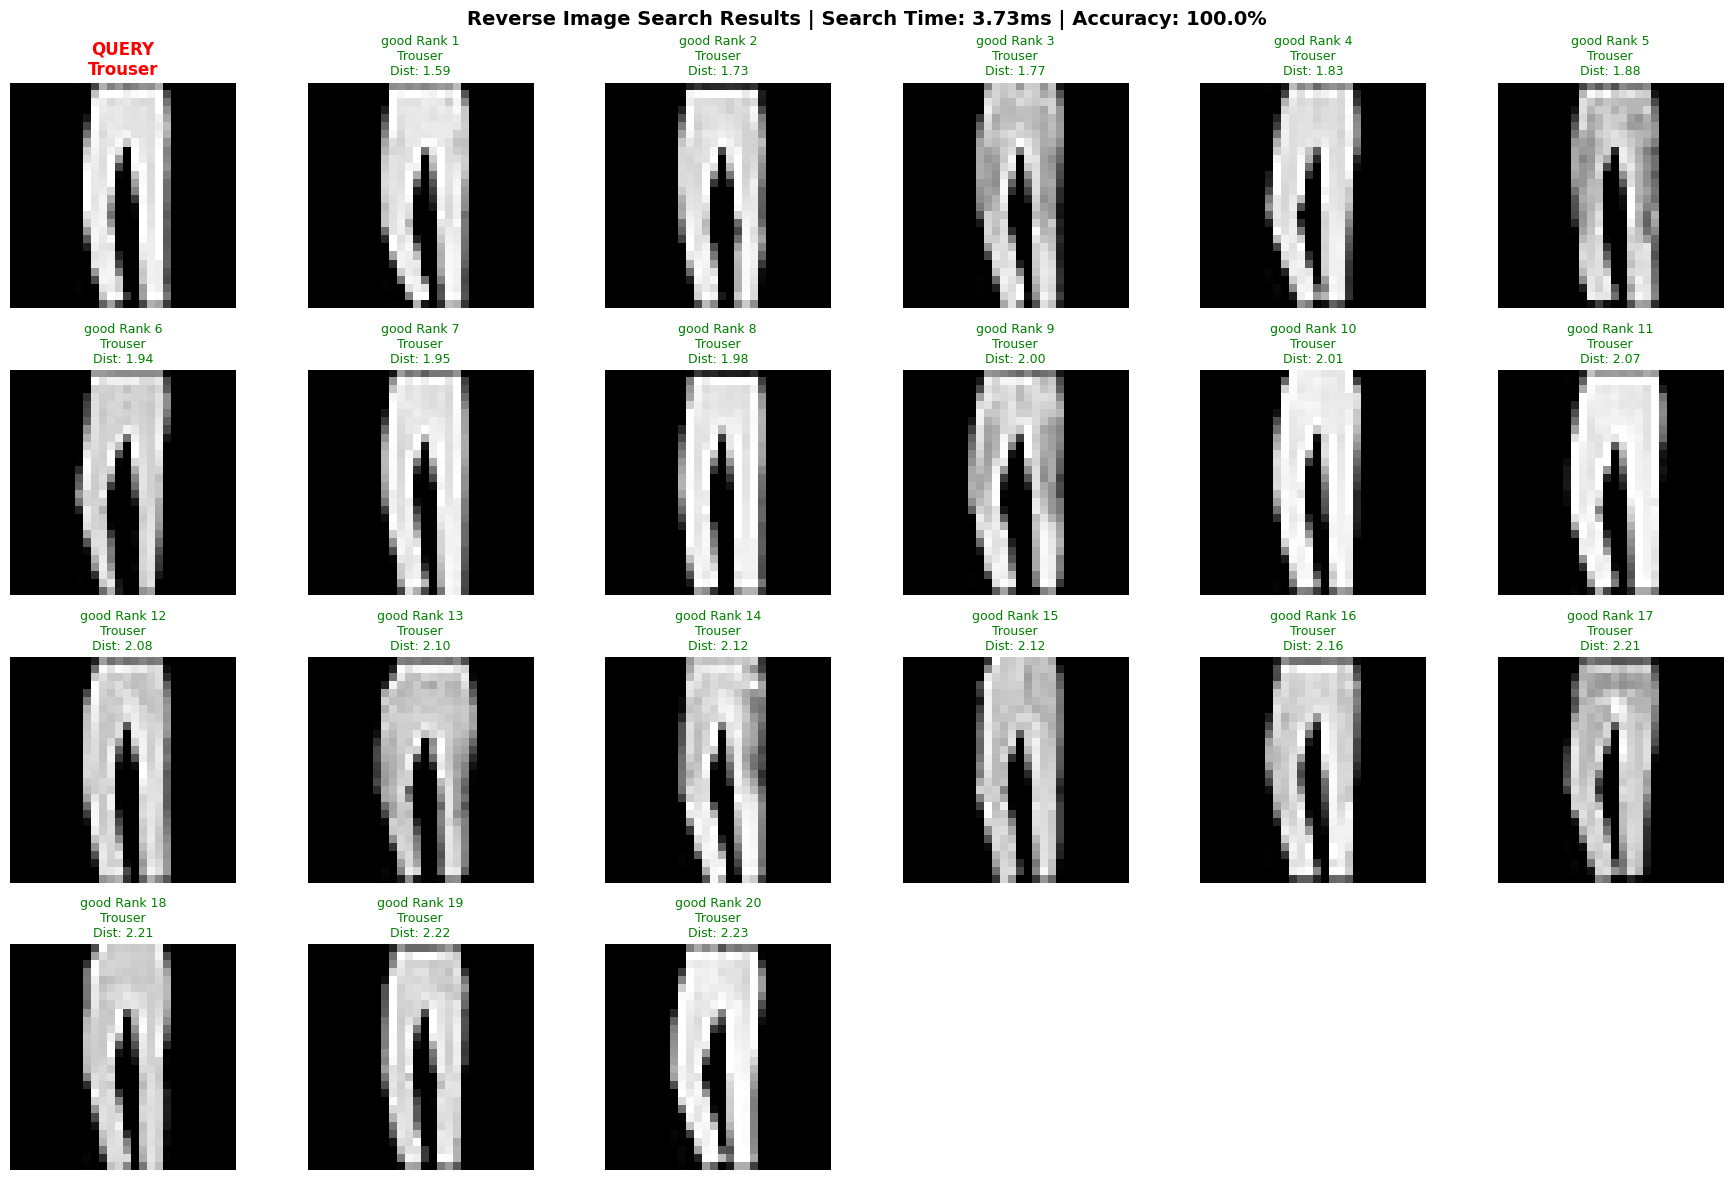

QUERY: Trouser
Search Time: 3.73 ms
Top-20 Accuracy: 1.0000

Rank   Match   Label           Distance  
----------------------------------------------------------------------
1      ✓       Trouser         1.5935    
2      ✓       Trouser         1.7256    
3      ✓       Trouser         1.7680    
4      ✓       Trouser         1.8317    
5      ✓       Trouser         1.8807    
6      ✓       Trouser         1.9400    
7      ✓       Trouser         1.9487    
8      ✓       Trouser         1.9829    
9      ✓       Trouser         2.0046    
10     ✓       Trouser         2.0051    
11     ✓       Trouser         2.0684    
12     ✓       Trouser         2.0765    
13     ✓       Trouser         2.0991    
14     ✓       Trouser         2.1182    
15     ✓       Trouser         2.1249    
16     ✓       Trouser         2.1623    
17     ✓       Trouser         2.2096    
18     ✓       Trouser         2.2116    
19     ✓       Trouser         2.2170    
20     ✓       Trouser      

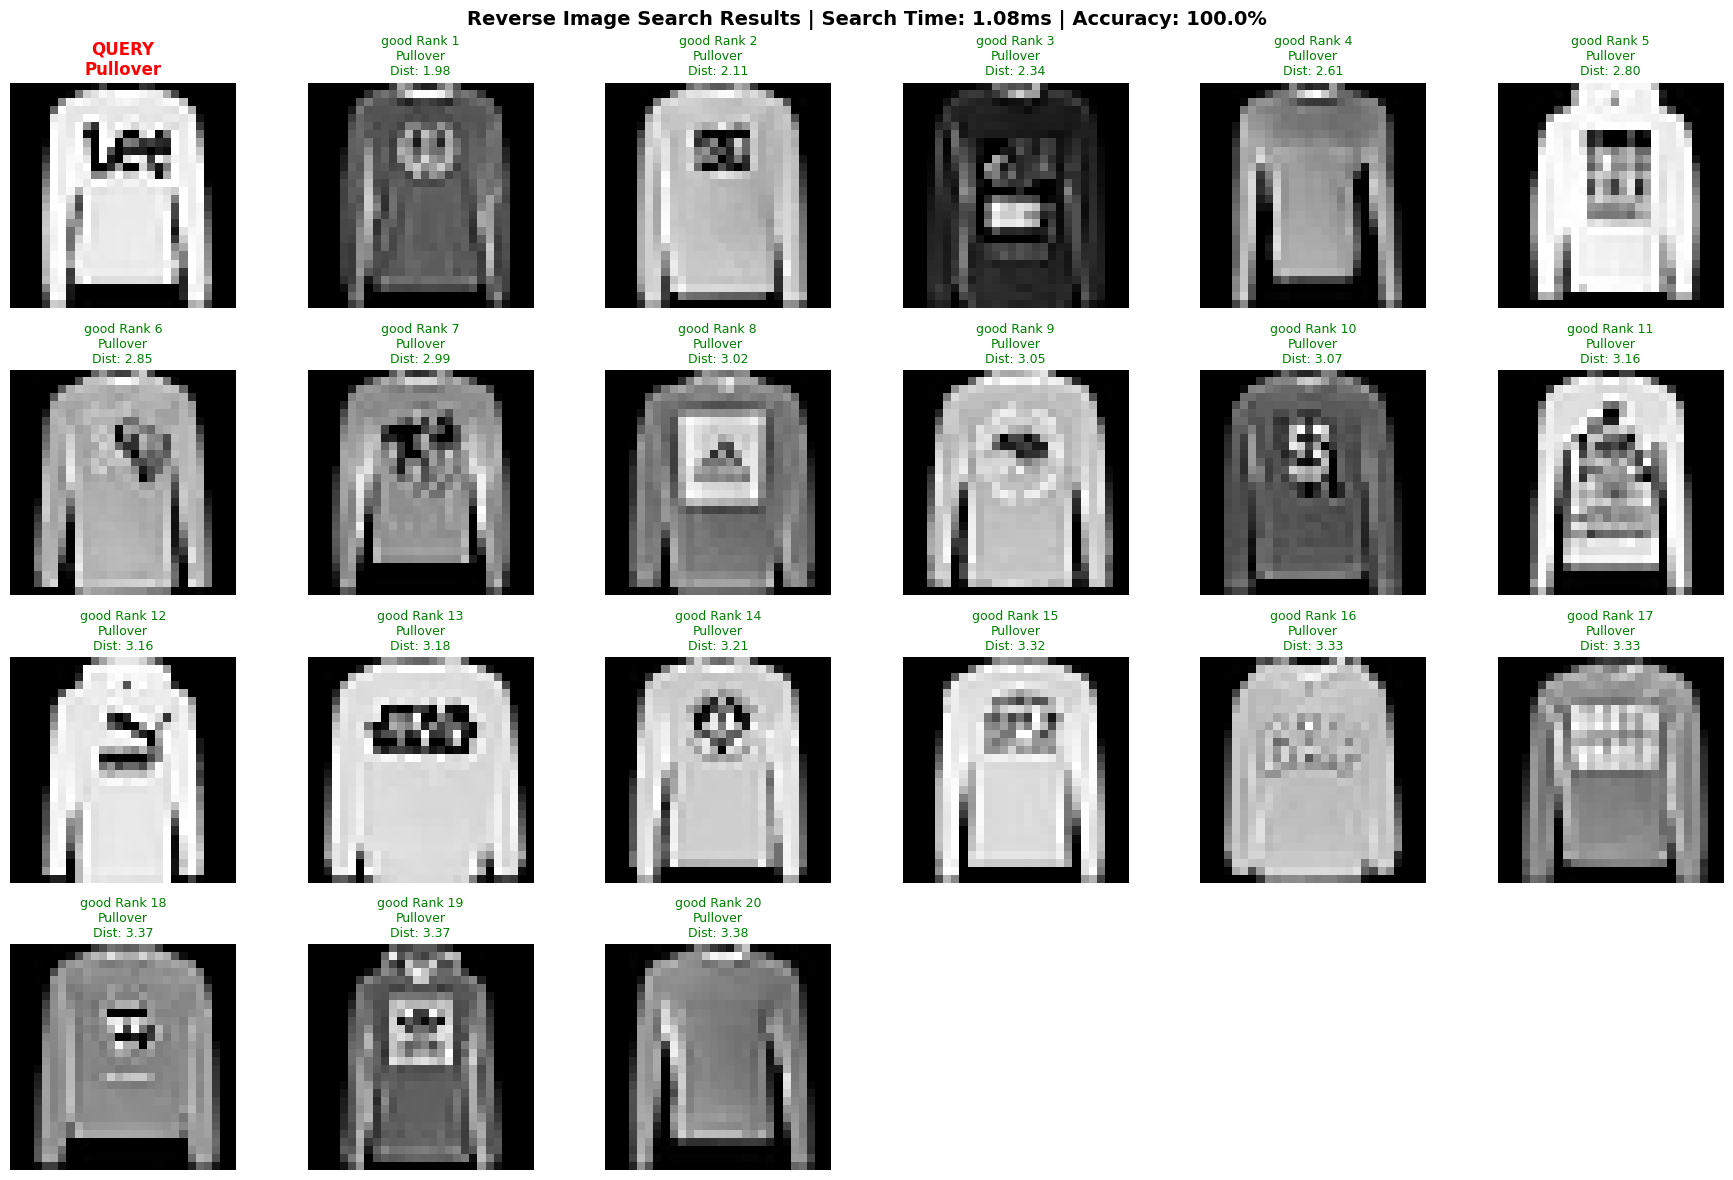

QUERY: Pullover
Search Time: 1.08 ms
Top-20 Accuracy: 1.0000

Rank   Match   Label           Distance  
----------------------------------------------------------------------
1      ✓       Pullover        1.9825    
2      ✓       Pullover        2.1075    
3      ✓       Pullover        2.3405    
4      ✓       Pullover        2.6094    
5      ✓       Pullover        2.7977    
6      ✓       Pullover        2.8540    
7      ✓       Pullover        2.9923    
8      ✓       Pullover        3.0225    
9      ✓       Pullover        3.0455    
10     ✓       Pullover        3.0715    
11     ✓       Pullover        3.1557    
12     ✓       Pullover        3.1565    
13     ✓       Pullover        3.1783    
14     ✓       Pullover        3.2144    
15     ✓       Pullover        3.3190    
16     ✓       Pullover        3.3257    
17     ✓       Pullover        3.3313    
18     ✓       Pullover        3.3658    
19     ✓       Pullover        3.3704    
20     ✓       Pullover    

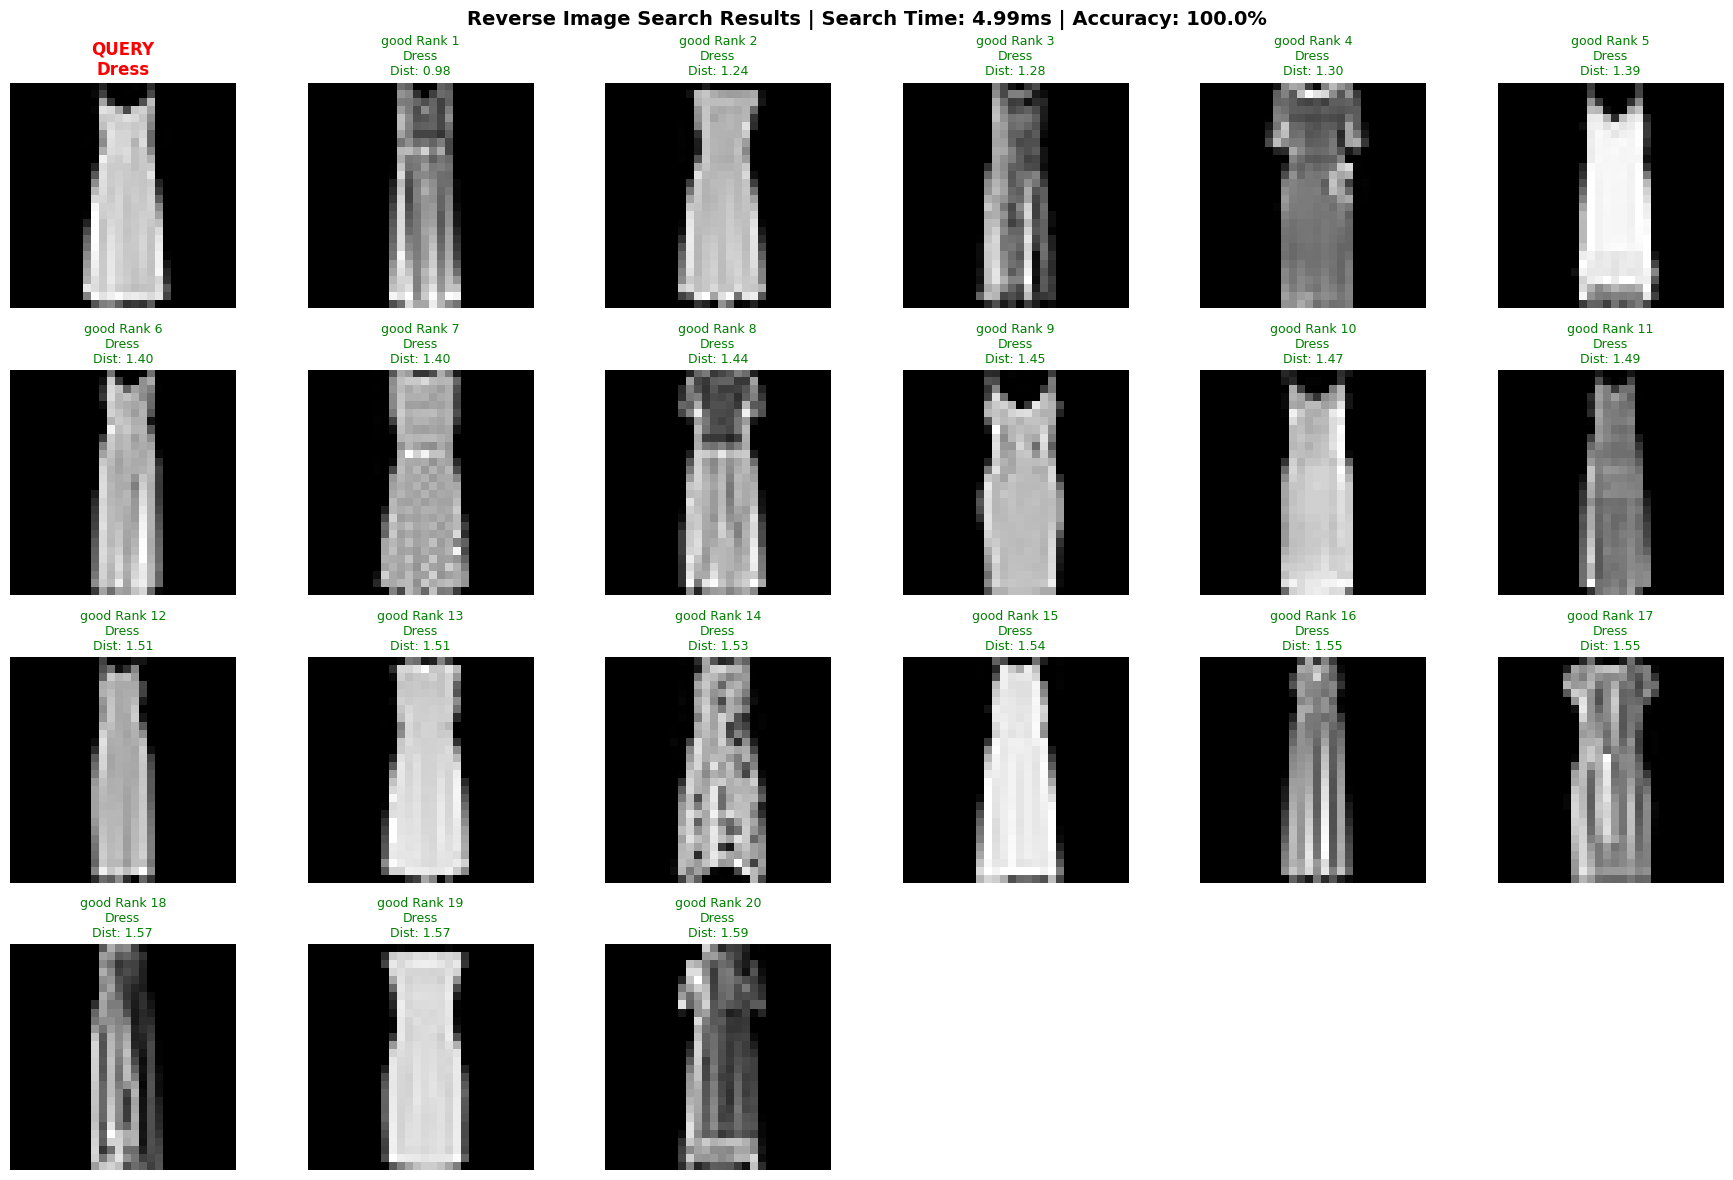

QUERY: Dress
Search Time: 4.99 ms
Top-20 Accuracy: 1.0000

Rank   Match   Label           Distance  
----------------------------------------------------------------------
1      ✓       Dress           0.9841    
2      ✓       Dress           1.2404    
3      ✓       Dress           1.2804    
4      ✓       Dress           1.3037    
5      ✓       Dress           1.3878    
6      ✓       Dress           1.3985    
7      ✓       Dress           1.3994    
8      ✓       Dress           1.4369    
9      ✓       Dress           1.4505    
10     ✓       Dress           1.4660    
11     ✓       Dress           1.4865    
12     ✓       Dress           1.5075    
13     ✓       Dress           1.5084    
14     ✓       Dress           1.5322    
15     ✓       Dress           1.5383    
16     ✓       Dress           1.5475    
17     ✓       Dress           1.5510    
18     ✓       Dress           1.5676    
19     ✓       Dress           1.5717    
20     ✓       Dress          

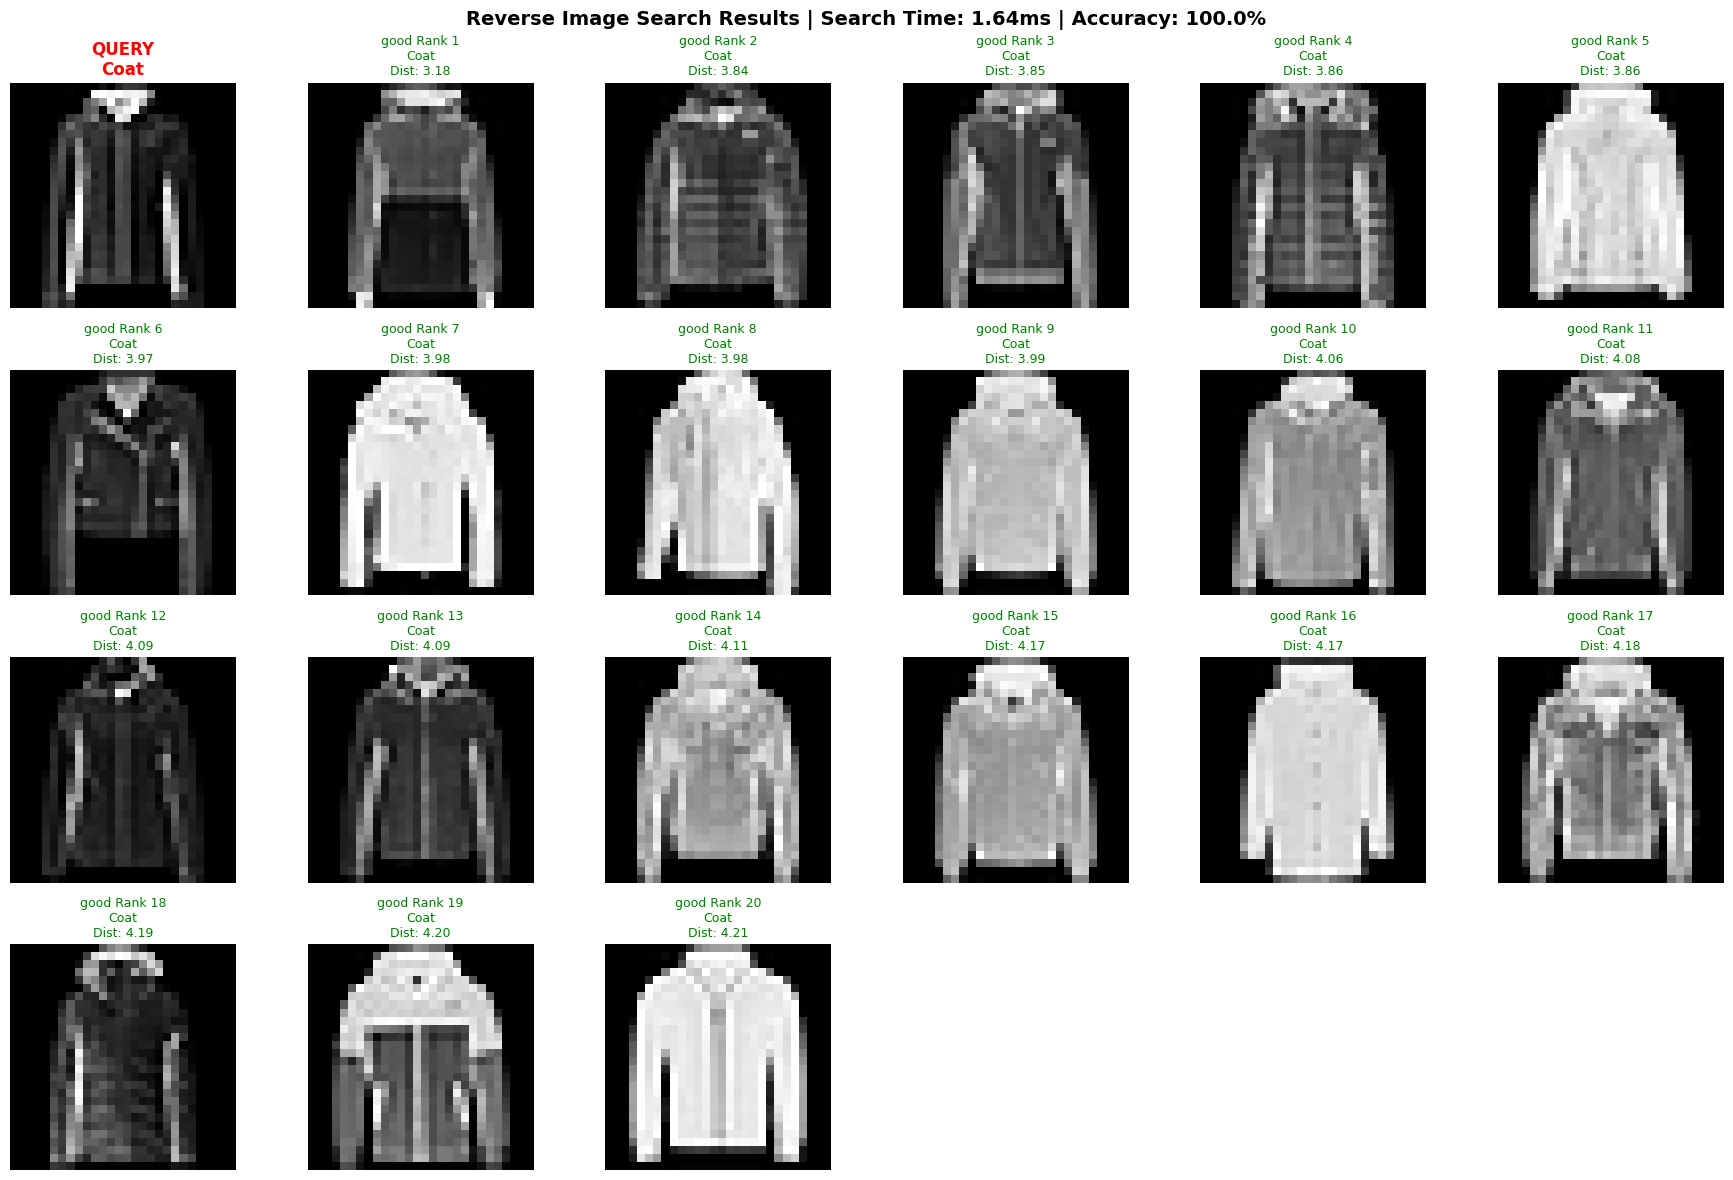

QUERY: Coat
Search Time: 1.64 ms
Top-20 Accuracy: 1.0000

Rank   Match   Label           Distance  
----------------------------------------------------------------------
1      ✓       Coat            3.1820    
2      ✓       Coat            3.8351    
3      ✓       Coat            3.8462    
4      ✓       Coat            3.8632    
5      ✓       Coat            3.8645    
6      ✓       Coat            3.9691    
7      ✓       Coat            3.9789    
8      ✓       Coat            3.9828    
9      ✓       Coat            3.9912    
10     ✓       Coat            4.0596    
11     ✓       Coat            4.0835    
12     ✓       Coat            4.0876    
13     ✓       Coat            4.0928    
14     ✓       Coat            4.1075    
15     ✓       Coat            4.1706    
16     ✓       Coat            4.1727    
17     ✓       Coat            4.1817    
18     ✓       Coat            4.1903    
19     ✓       Coat            4.2036    
20     ✓       Coat            

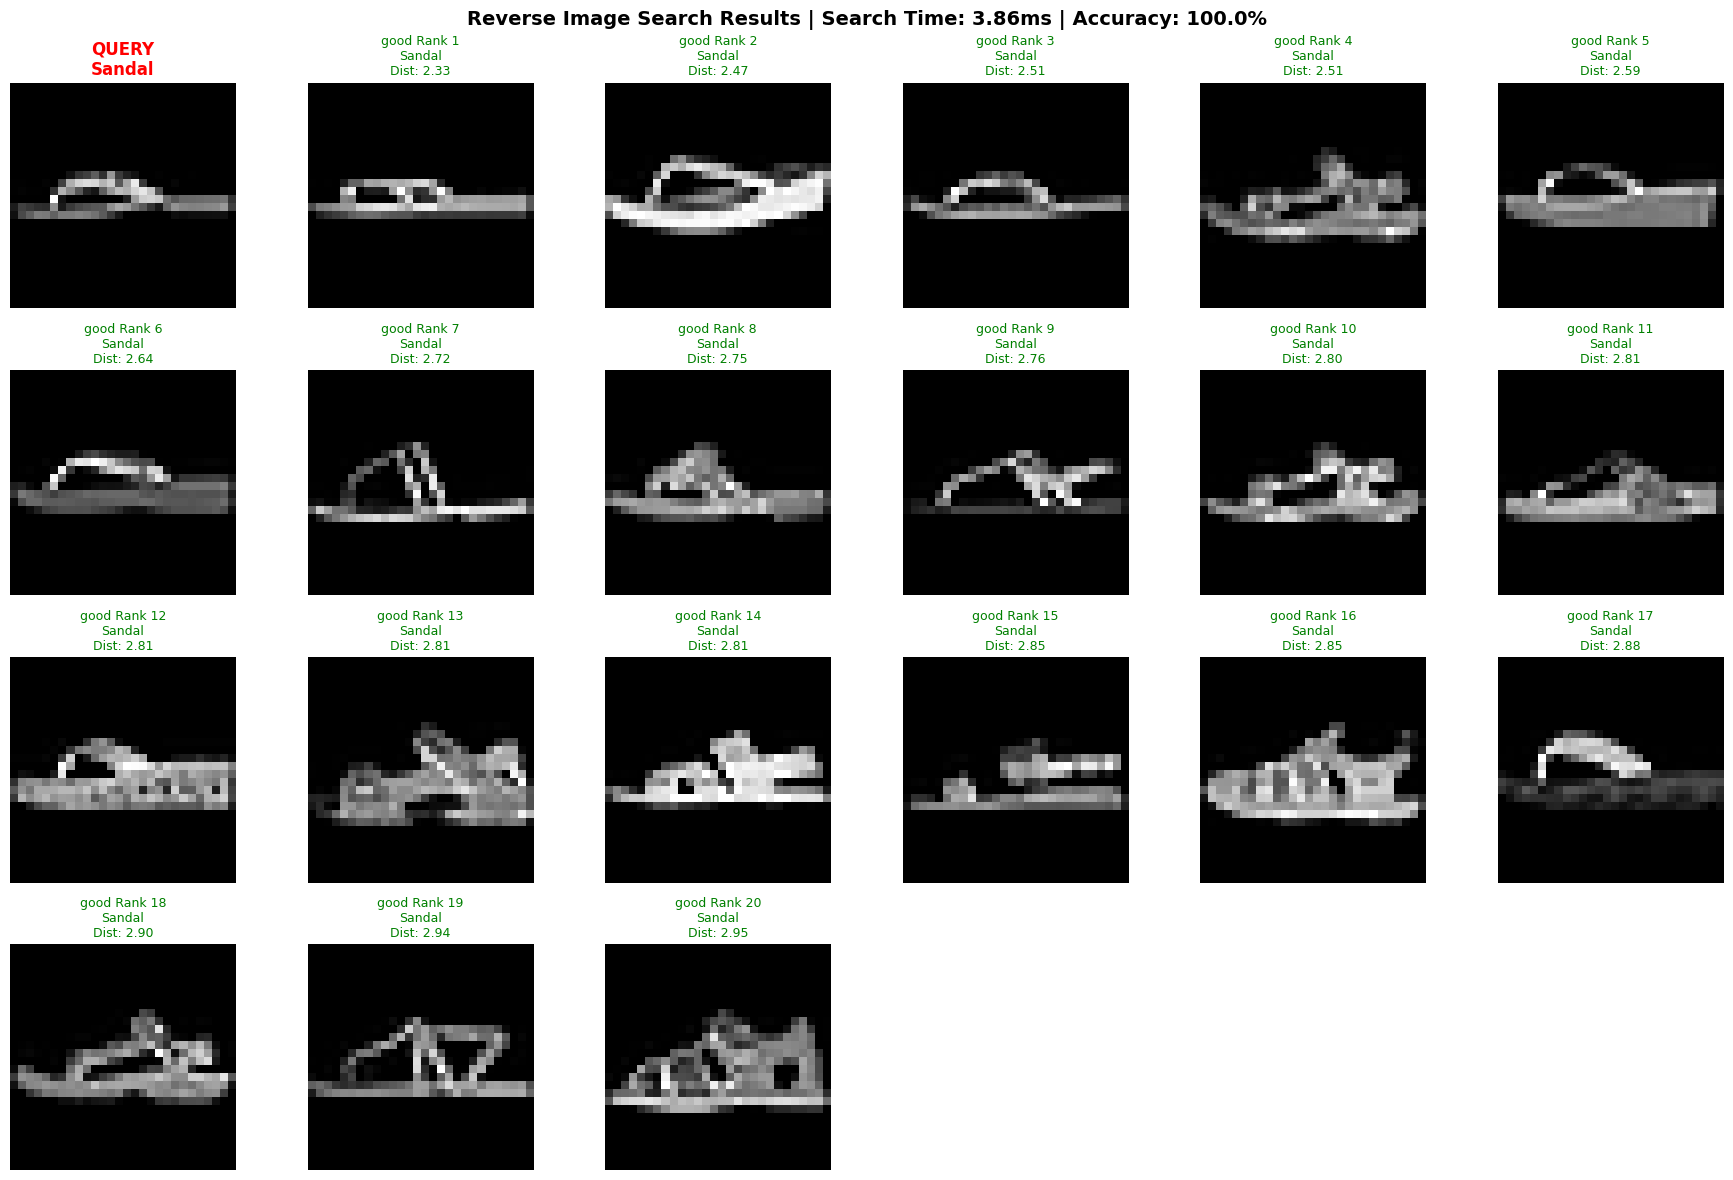

QUERY: Sandal
Search Time: 3.86 ms
Top-20 Accuracy: 1.0000

Rank   Match   Label           Distance  
----------------------------------------------------------------------
1      ✓       Sandal          2.3307    
2      ✓       Sandal          2.4743    
3      ✓       Sandal          2.5121    
4      ✓       Sandal          2.5148    
5      ✓       Sandal          2.5900    
6      ✓       Sandal          2.6407    
7      ✓       Sandal          2.7174    
8      ✓       Sandal          2.7512    
9      ✓       Sandal          2.7560    
10     ✓       Sandal          2.7960    
11     ✓       Sandal          2.8097    
12     ✓       Sandal          2.8098    
13     ✓       Sandal          2.8138    
14     ✓       Sandal          2.8144    
15     ✓       Sandal          2.8493    
16     ✓       Sandal          2.8507    
17     ✓       Sandal          2.8767    
18     ✓       Sandal          2.9045    
19     ✓       Sandal          2.9390    
20     ✓       Sandal        

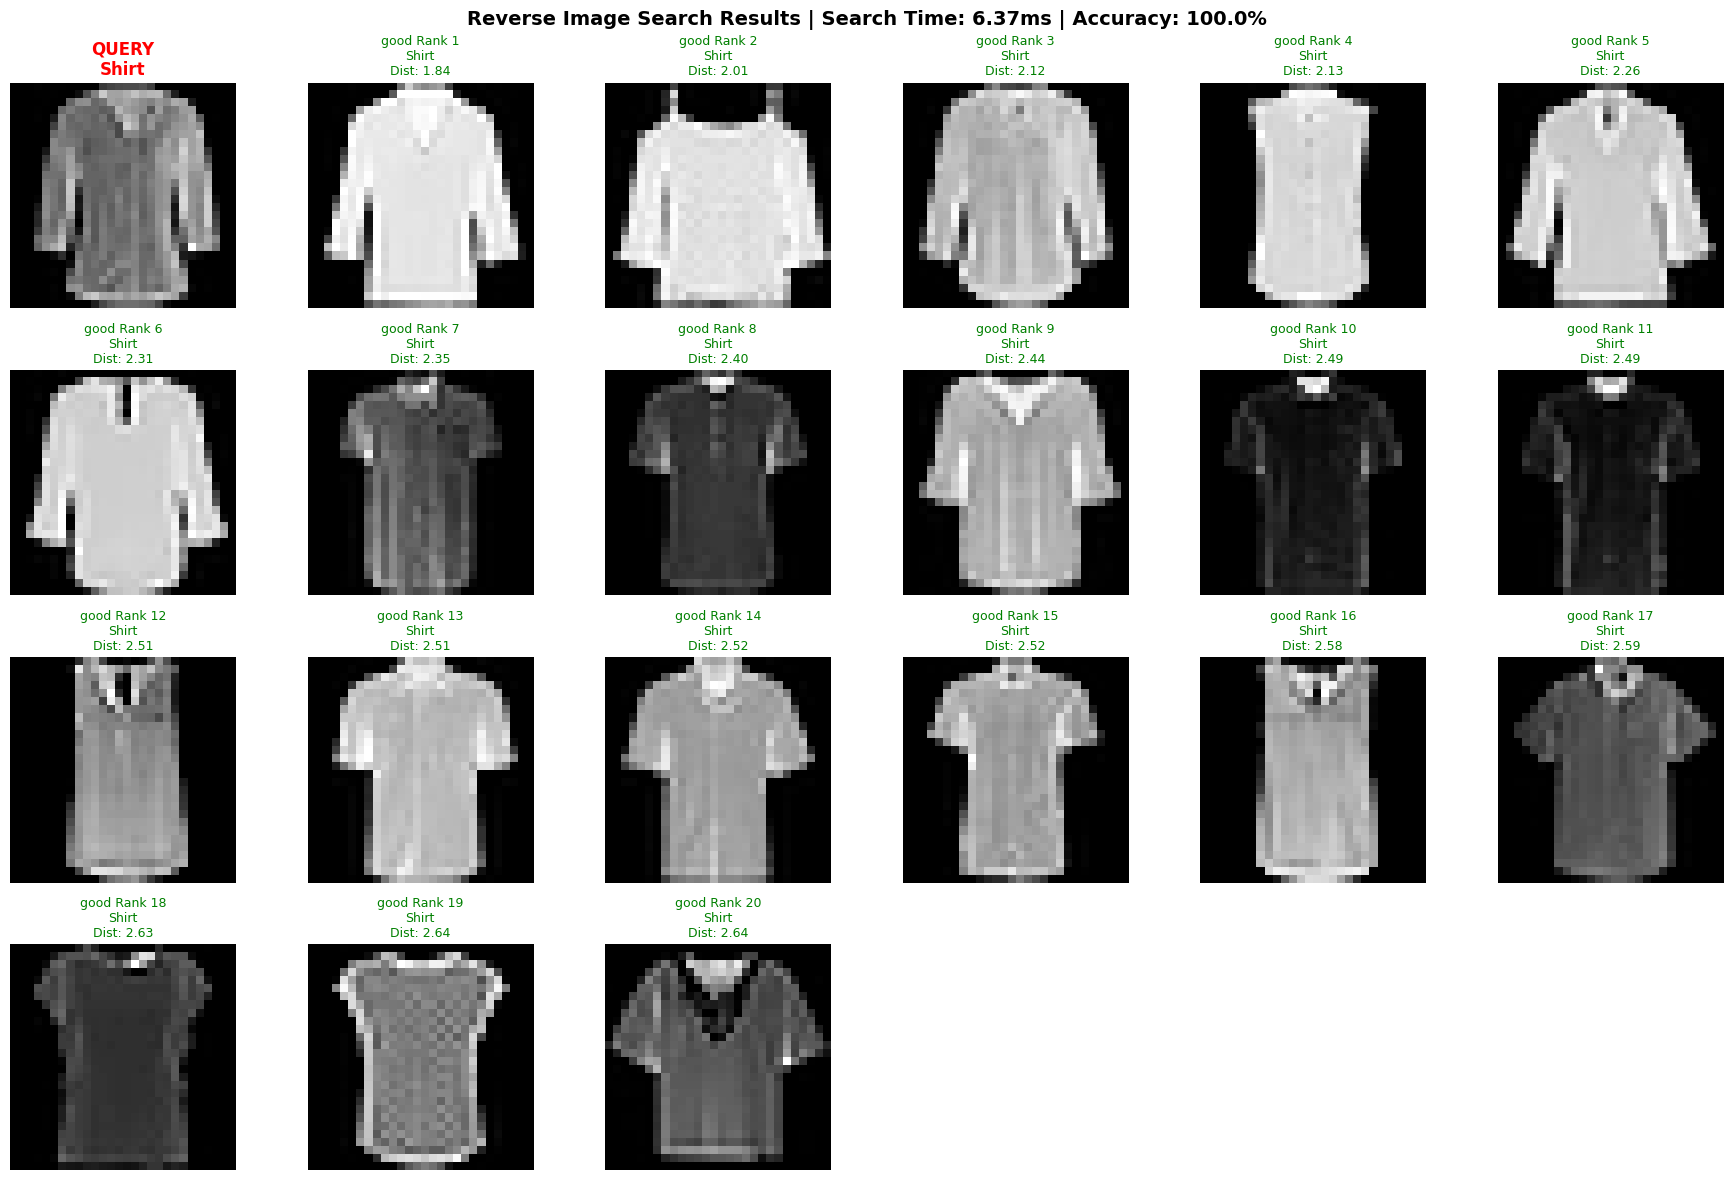

QUERY: Shirt
Search Time: 6.37 ms
Top-20 Accuracy: 1.0000

Rank   Match   Label           Distance  
----------------------------------------------------------------------
1      ✓       Shirt           1.8436    
2      ✓       Shirt           2.0111    
3      ✓       Shirt           2.1172    
4      ✓       Shirt           2.1336    
5      ✓       Shirt           2.2591    
6      ✓       Shirt           2.3086    
7      ✓       Shirt           2.3451    
8      ✓       Shirt           2.3963    
9      ✓       Shirt           2.4372    
10     ✓       Shirt           2.4853    
11     ✓       Shirt           2.4923    
12     ✓       Shirt           2.5058    
13     ✓       Shirt           2.5129    
14     ✓       Shirt           2.5189    
15     ✓       Shirt           2.5224    
16     ✓       Shirt           2.5811    
17     ✓       Shirt           2.5918    
18     ✓       Shirt           2.6282    
19     ✓       Shirt           2.6390    
20     ✓       Shirt          

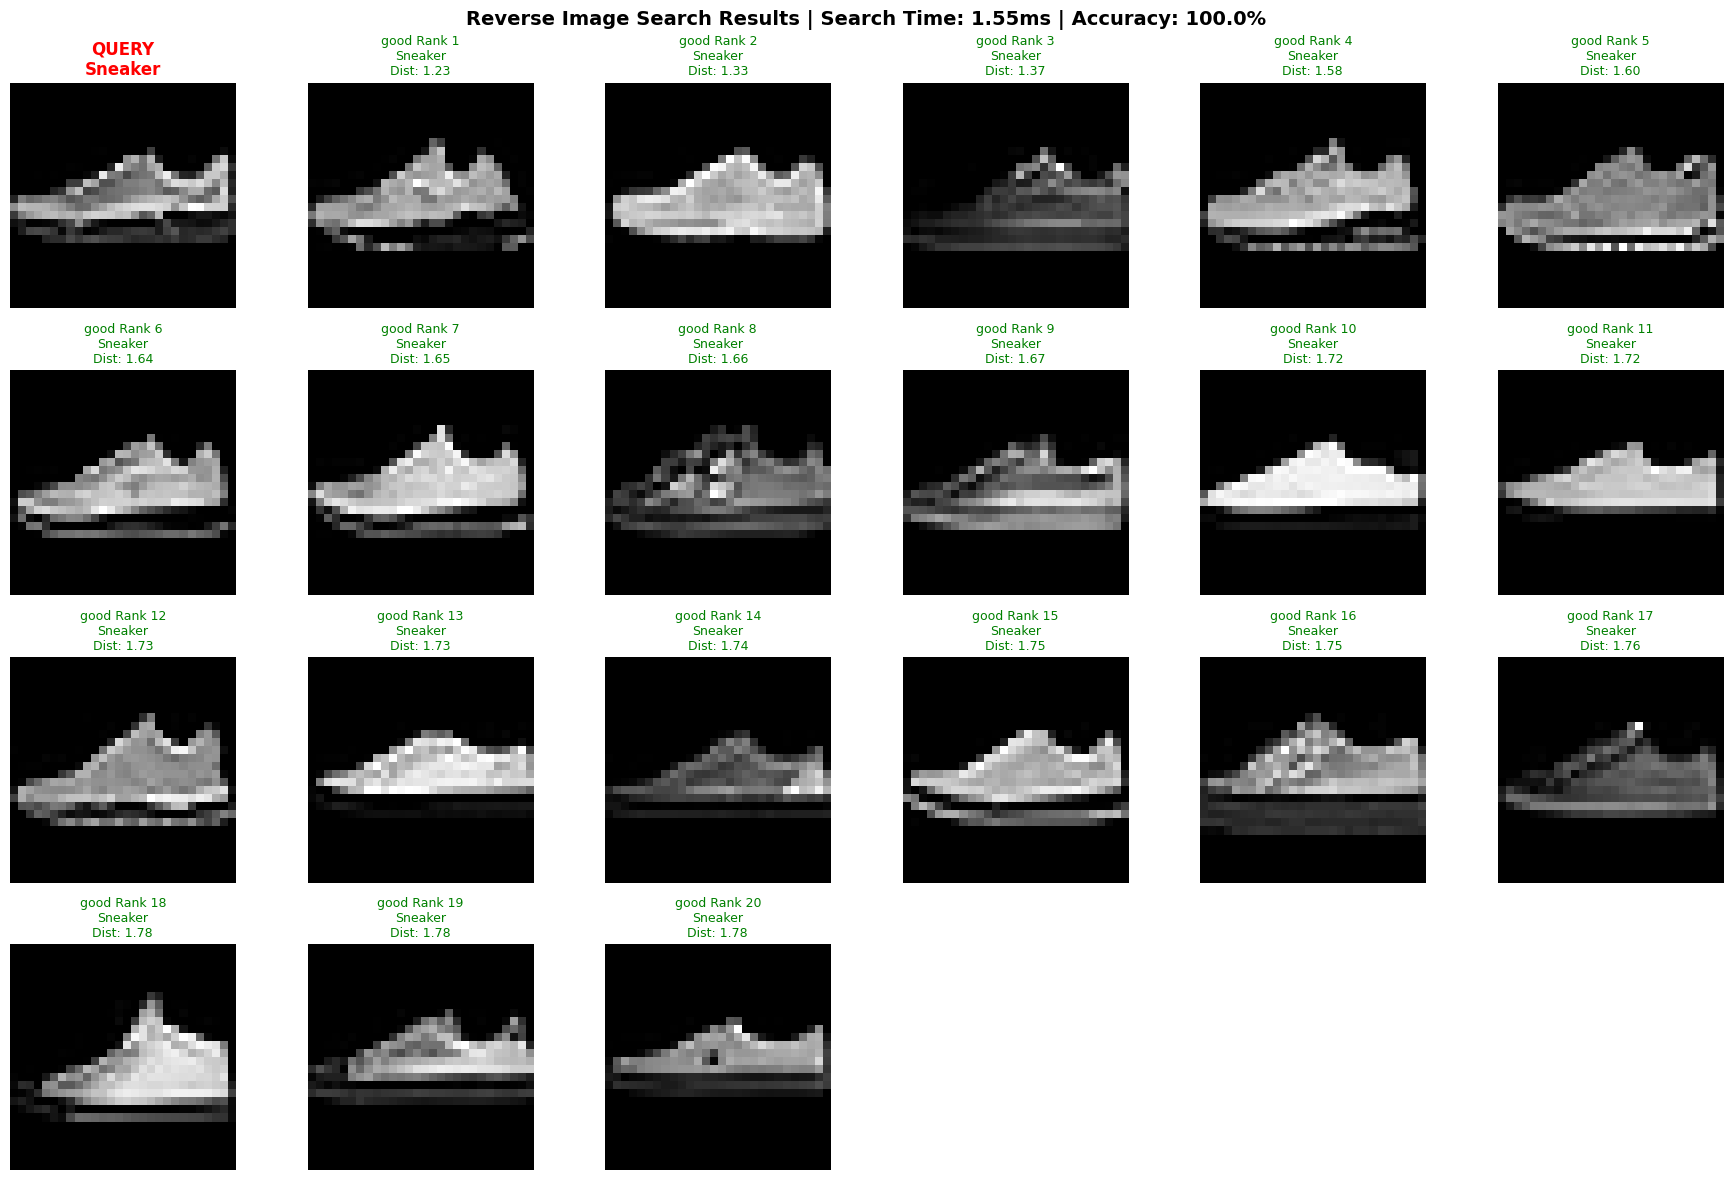

QUERY: Sneaker
Search Time: 1.55 ms
Top-20 Accuracy: 1.0000

Rank   Match   Label           Distance  
----------------------------------------------------------------------
1      ✓       Sneaker         1.2336    
2      ✓       Sneaker         1.3279    
3      ✓       Sneaker         1.3703    
4      ✓       Sneaker         1.5813    
5      ✓       Sneaker         1.5975    
6      ✓       Sneaker         1.6397    
7      ✓       Sneaker         1.6536    
8      ✓       Sneaker         1.6555    
9      ✓       Sneaker         1.6680    
10     ✓       Sneaker         1.7174    
11     ✓       Sneaker         1.7201    
12     ✓       Sneaker         1.7272    
13     ✓       Sneaker         1.7335    
14     ✓       Sneaker         1.7356    
15     ✓       Sneaker         1.7520    
16     ✓       Sneaker         1.7549    
17     ✓       Sneaker         1.7582    
18     ✓       Sneaker         1.7766    
19     ✓       Sneaker         1.7823    
20     ✓       Sneaker      

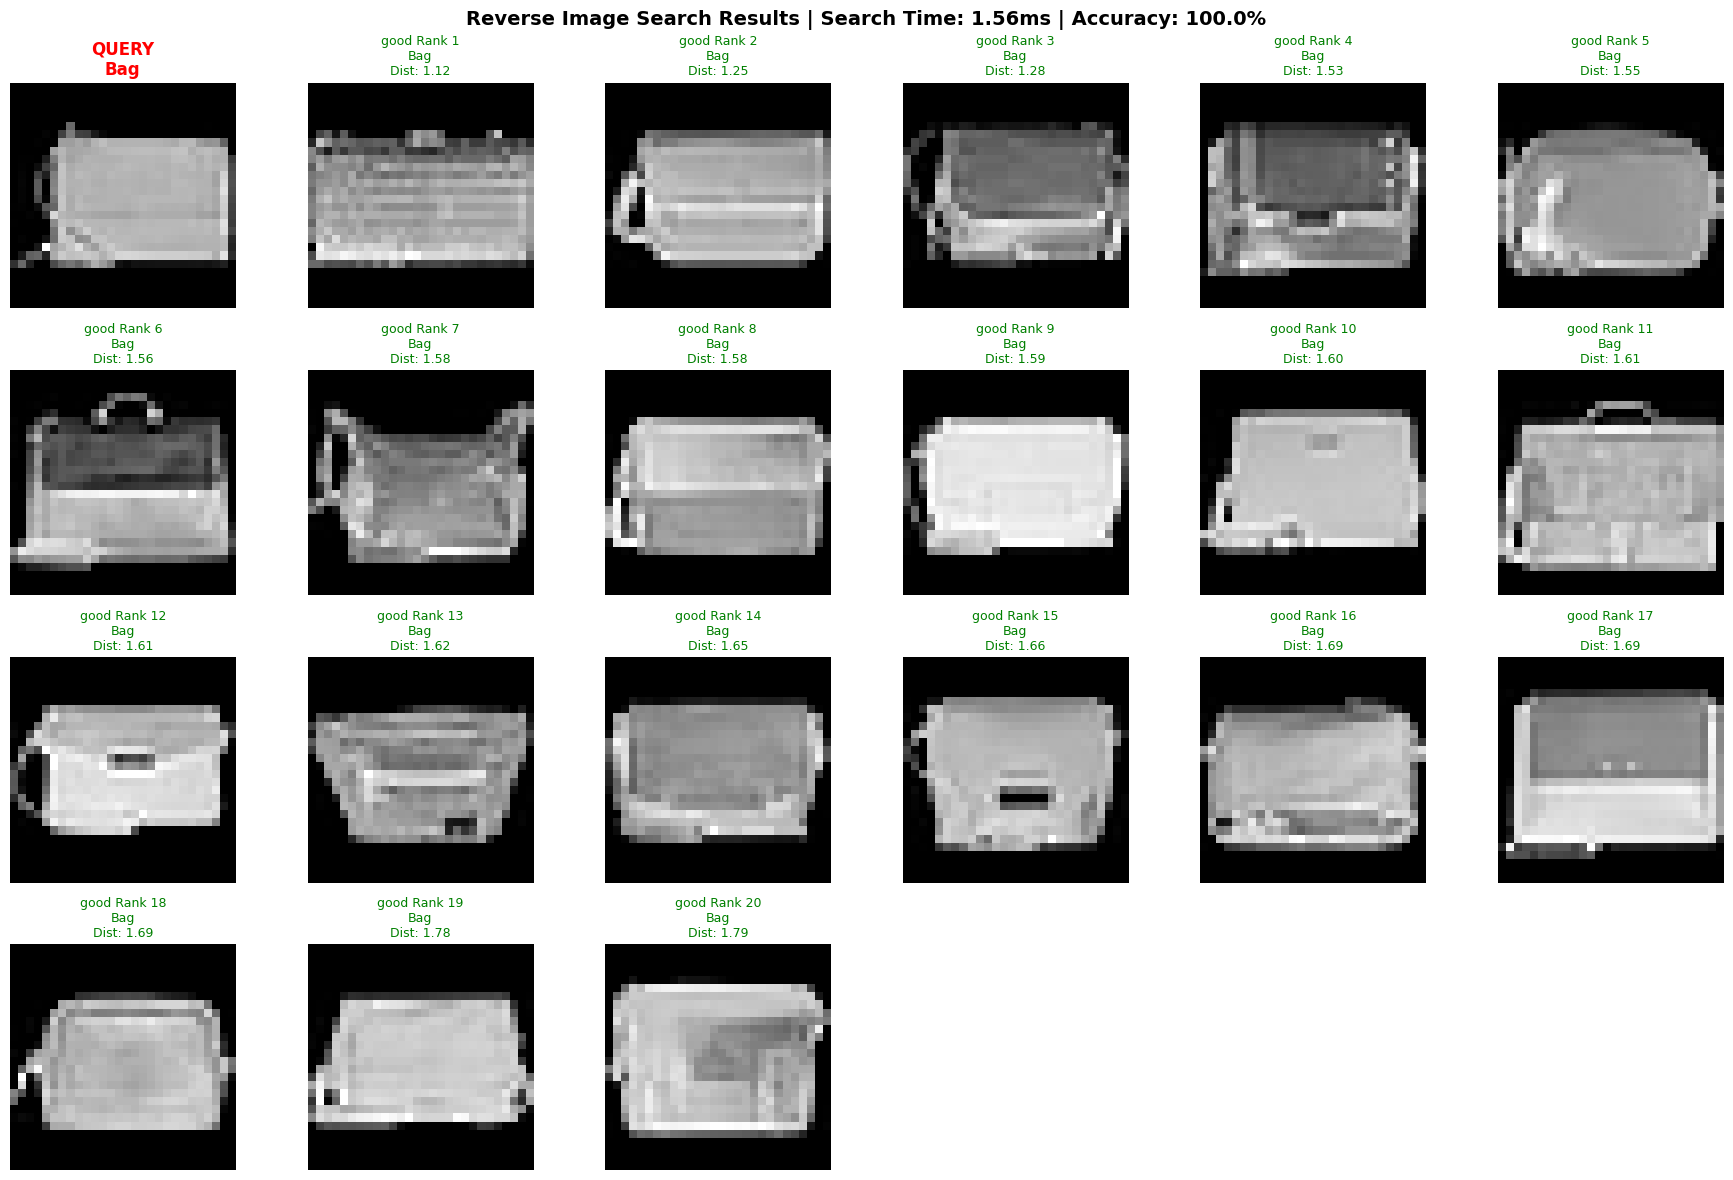

QUERY: Bag
Search Time: 1.56 ms
Top-20 Accuracy: 1.0000

Rank   Match   Label           Distance  
----------------------------------------------------------------------
1      ✓       Bag             1.1209    
2      ✓       Bag             1.2540    
3      ✓       Bag             1.2768    
4      ✓       Bag             1.5338    
5      ✓       Bag             1.5517    
6      ✓       Bag             1.5636    
7      ✓       Bag             1.5754    
8      ✓       Bag             1.5775    
9      ✓       Bag             1.5867    
10     ✓       Bag             1.5952    
11     ✓       Bag             1.6090    
12     ✓       Bag             1.6147    
13     ✓       Bag             1.6196    
14     ✓       Bag             1.6514    
15     ✓       Bag             1.6569    
16     ✓       Bag             1.6854    
17     ✓       Bag             1.6878    
18     ✓       Bag             1.6901    
19     ✓       Bag             1.7758    
20     ✓       Bag             1

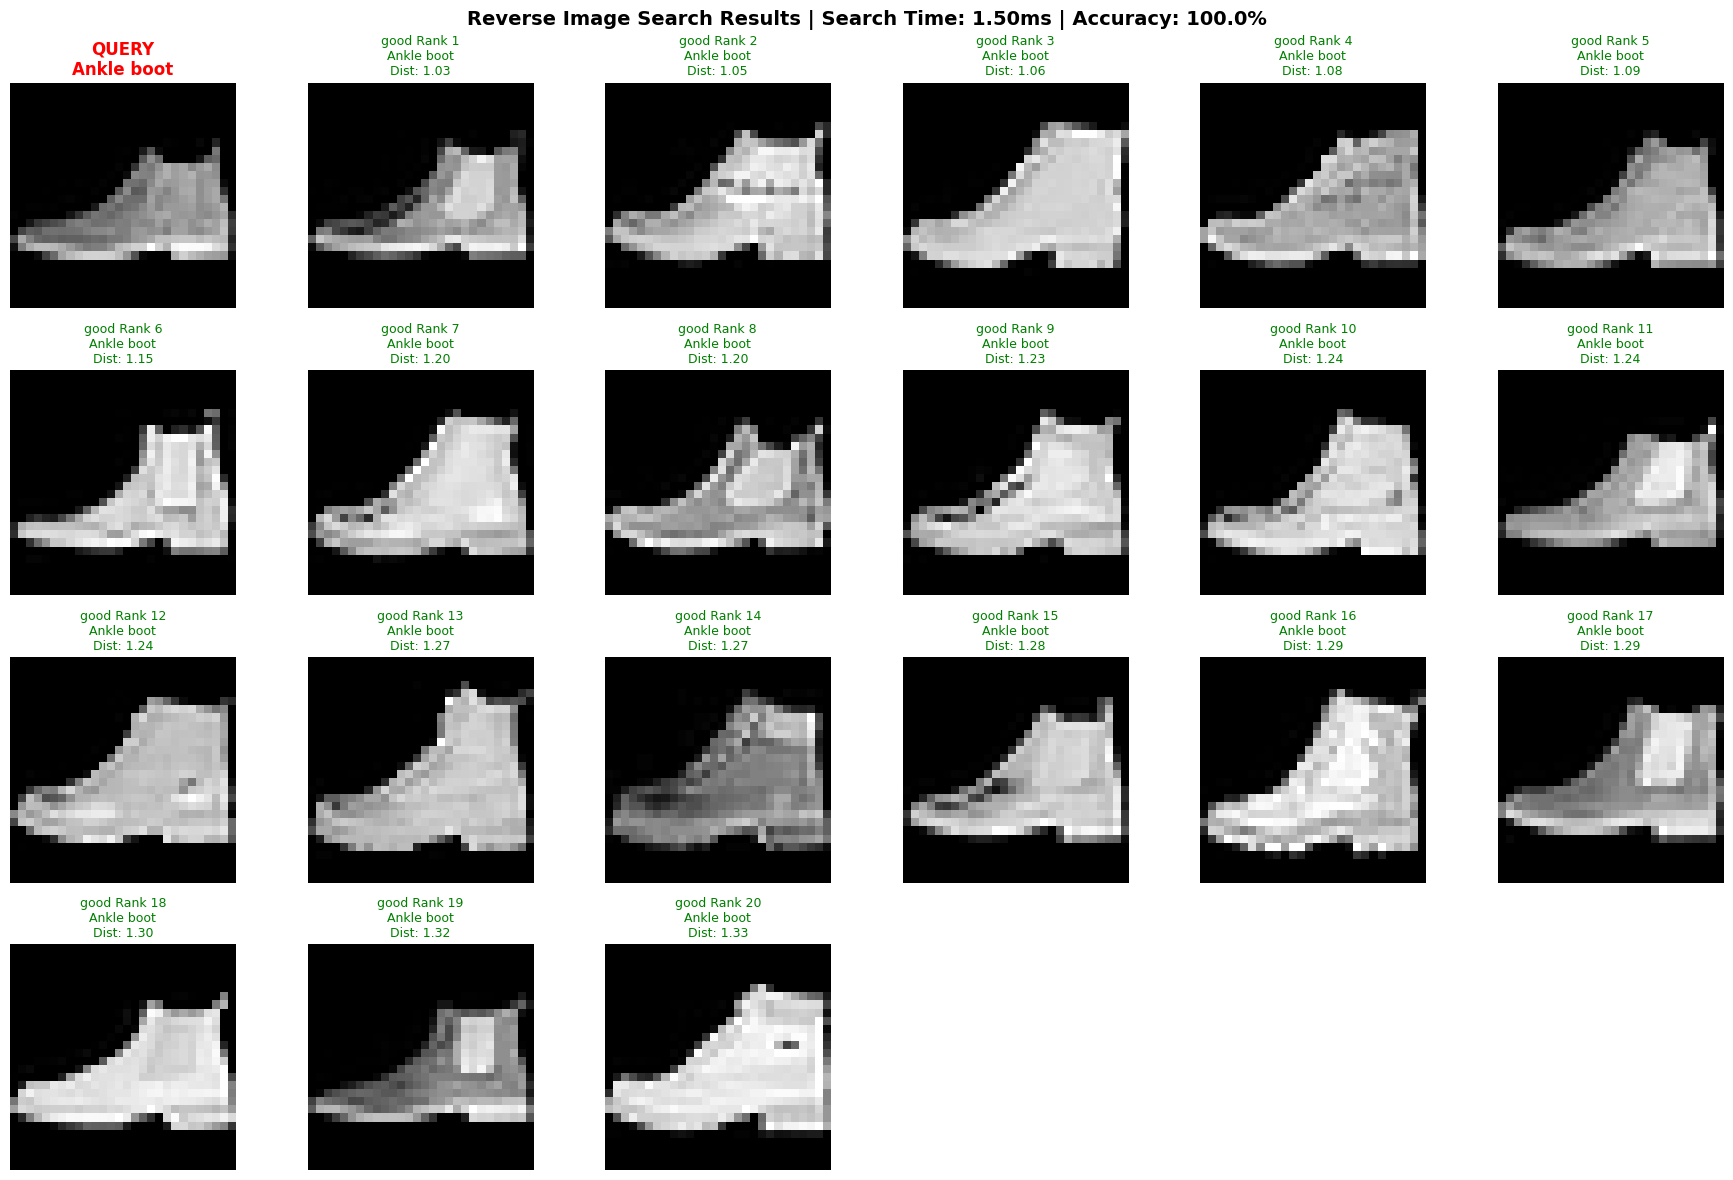

QUERY: Ankle boot
Search Time: 1.50 ms
Top-20 Accuracy: 1.0000

Rank   Match   Label           Distance  
----------------------------------------------------------------------
1      ✓       Ankle boot      1.0259    
2      ✓       Ankle boot      1.0519    
3      ✓       Ankle boot      1.0604    
4      ✓       Ankle boot      1.0787    
5      ✓       Ankle boot      1.0851    
6      ✓       Ankle boot      1.1476    
7      ✓       Ankle boot      1.2000    
8      ✓       Ankle boot      1.2017    
9      ✓       Ankle boot      1.2344    
10     ✓       Ankle boot      1.2355    
11     ✓       Ankle boot      1.2355    
12     ✓       Ankle boot      1.2381    
13     ✓       Ankle boot      1.2684    
14     ✓       Ankle boot      1.2741    
15     ✓       Ankle boot      1.2847    
16     ✓       Ankle boot      1.2852    
17     ✓       Ankle boot      1.2917    
18     ✓       Ankle boot      1.2996    
19     ✓       Ankle boot      1.3210    
20     ✓       Ankle boot

In [ ]:
print("DISPLAYING REVERSE SEARCH RESULTS (Euclidean Distance)")

for i, (query_img, query_label) in enumerate(query_examples):
    print(f"\n{'Query ' + str(i+1) + ': ' + CLASS_NAMES[query_label]:}")
    visualize_search_results(
        query_img,
        query_label,
        search_engine_euclidean, # Using the Euclidean search engine
        X_train_split, # Database images (training set)
        y_train_split, # Database labels (training set)
        k=20
    )